In [40]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import yfinance as yf

In [41]:
#Importing daily OHLC data from yahoo finance 
#Data is for Nasdaq 100 composite index by Inveso

df = yf.download("QQQ").reset_index()
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-03-10,51.12500,51.156250,50.28125,51.0625,43.715046,5232000
1,1999-03-11,51.43750,51.734375,50.31250,51.3125,43.929073,9688600
2,1999-03-12,51.12500,51.156250,49.65625,50.0625,42.858940,8743600
3,1999-03-15,50.43750,51.562500,49.90625,51.5000,44.089607,6369000
4,1999-03-16,51.71875,52.156250,51.15625,51.9375,44.464149,4905800


In [42]:
#Create a target variable
#The question we want to answer is for example: 
# Will the index be above or below its 20SMA in 5 days 
# We create a target moving average and then variables to identify if price is above or below

df['target_ma'] = df['Close'].rolling(20).mean()
df['price_above_ma'] = df['Close'] > df['target_ma']
df['target'] = df['price_above_ma'].astype(int).shift(-5)


In [43]:
#Create features
#The model needs standardized features to learn from 
#We use 3 types:
# 1. % change between price and SMA
# 2. % change from the price and rolling max/min
# 3. % change from the price n days ago

for m in [10,20,30,50,100]: 
    df[f'feat_dist_from_ma_{m}'] = df['Close']/df['Close'].rolling(m).mean()-1

for m in [3,5,10,15,20,30,50,100]: 
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['Close'].rolling(m).max()-1
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['Close'].rolling(m).max()-1

for m in [1,2,3,5,10,15,20,30,50,100]: 
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['Close'].rolling(m).max()-1
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['Close'].rolling(m).max()-1

In [47]:
# Split data into train and test 
# We train up to the start of 2019 and test on data beyond that
# We recongnize this is not optimal in that regimes change in markets
# We will apply a k-fold cross validation in an upgraded version

df = df.dropna()

feat_cols = [col for col in df.columns if 'feat' in col] 
train_until = '2019-01-01'

x_train = df[df['Date'] < train_until][feat_cols]
y_train = df[df['Date'] < train_until]['target']

x_test = df[df['Date'] >= train_until][feat_cols]
y_test = df[df['Date'] >= train_until]['target']

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42,
    class_weight='balanced',
)

clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Calculate accuracy and precision for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

# Calculate accuracy and precision for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precision: {train_precision}')
print('')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')

/Users/stan.motte/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Training Accuracy: 0.7133210558624923
Training Precision: 0.7758046614872364

Test Accuracy: 0.7832792207792207
Test Precision: 0.8670212765957447


4887

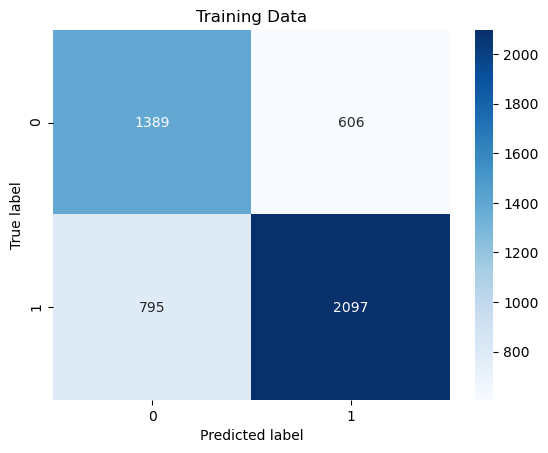

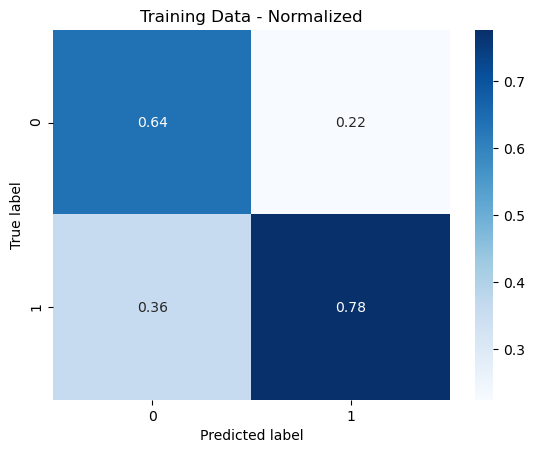

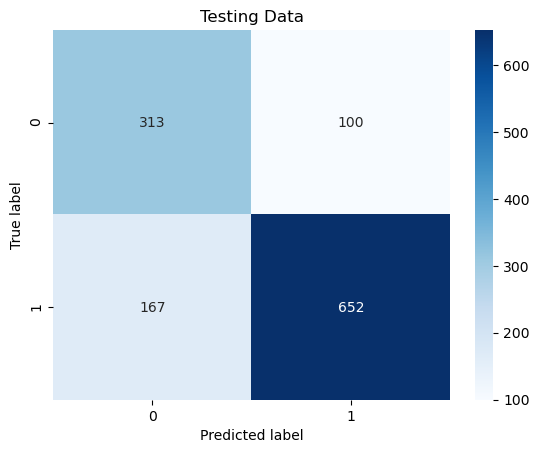

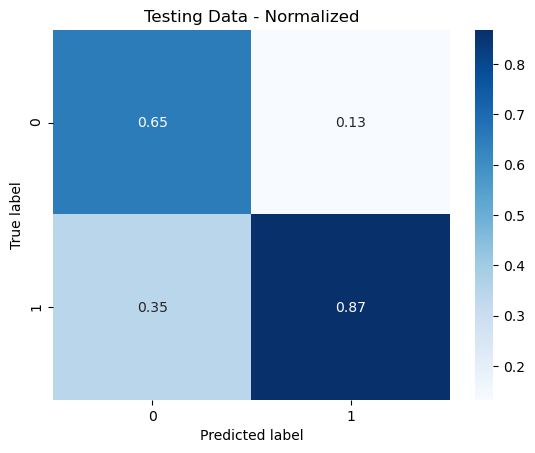

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, normalize):

    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize='pred')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    else:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return
    
plot_confusion_matrix(y_train, y_train_pred, title='Training Data', normalize=False)
plot_confusion_matrix(y_train, y_train_pred, title='Training Data - Normalized', normalize=True)

plot_confusion_matrix(y_test, y_test_pred, title='Testing Data', normalize=False)
plot_confusion_matrix(y_test, y_test_pred, title='Testing Data - Normalized', normalize=True)